## Standard Star Calibration for KCWI data

  
This routine can be used as an alternative to KCWI pipeline **stage 8** if the standard star contains a lot of features.  
https://github.com/Keck-DataReductionPipelines/KcwiDRP  
  
  
There are two steps:
1. Create a master standard star fit. The default is a polynomial fit without masking. But an spline option is also available in case the polynomial fit doesn't work if the features get complicated. An interactive plot of the data and the fit will be displayed.  
      First run with default setting and without masking to pick the ranges of wavelengths to ignore using the interactive plots. Make sure the fit looks good before proceed to the next step.
2. Do calibration based on the inverse sensitivity from the standard star fitting.

##### Preparation
Packages:
1. Install plotly with  
``conda install -c plotly plotly=4.9.0``  
2. And for saving plots  
``conda install -c plotly plotly-orca``
3. Also make sure you have these  
``conda install "notebook>=5.3" "ipywidgets>=7.2"``


Required files:
1. Standard star from stage 7 (icubed & dcubed), e.g. kb190101_00011_icubed.fits, kb190101_00011_dcubed.fits
2. Standard star sample, this can be found in the pipeline data directory, e.g. feige15.fits  
https://github.com/Keck-DataReductionPipelines/KcwiDRP/tree/master/data
3. The intensity, variance and mask cubes for objects to be calibrated from stage 7. e.g. *icubed.fits, *vcubed.fits, mcubed.fits
4. **Palomar extinction coefficients, this can be found in the kcwi_tools repository, just put it in the working directory.

Optional file:
- (Spline) To pick out the good points and ignore the features, wavelengths of points to be used for interpolation needs to be put in a column in dat/txt. An example points file for feige15 is in this repository.
- (Polynomial) In order to mask out the features in the polynomial standard star fitting, a mask file is needed to indicate the starting and ending points of the masked wavelengths. An example mask file for feige15 can be found in the same respository.

##### Functions
1. Make standard star: ``make_st(st_icube,st_file,*poly=True,*maskd=False,*deg=7,*mask=msk_file)``
2. Calibration: ``stage8std(obj_icubed,i_f)``

##### Return
1. Step 1 returns two structured arrays containing the fits for inverse sensitivity and effective area and automatically save the plots of the fits.
2. Step 2 returns the calibrated datacubes as \*icubes, \*vcubes, and \*mcubes in the same directory as the input \*icubed file of the object.

##### Theoretical
<div>
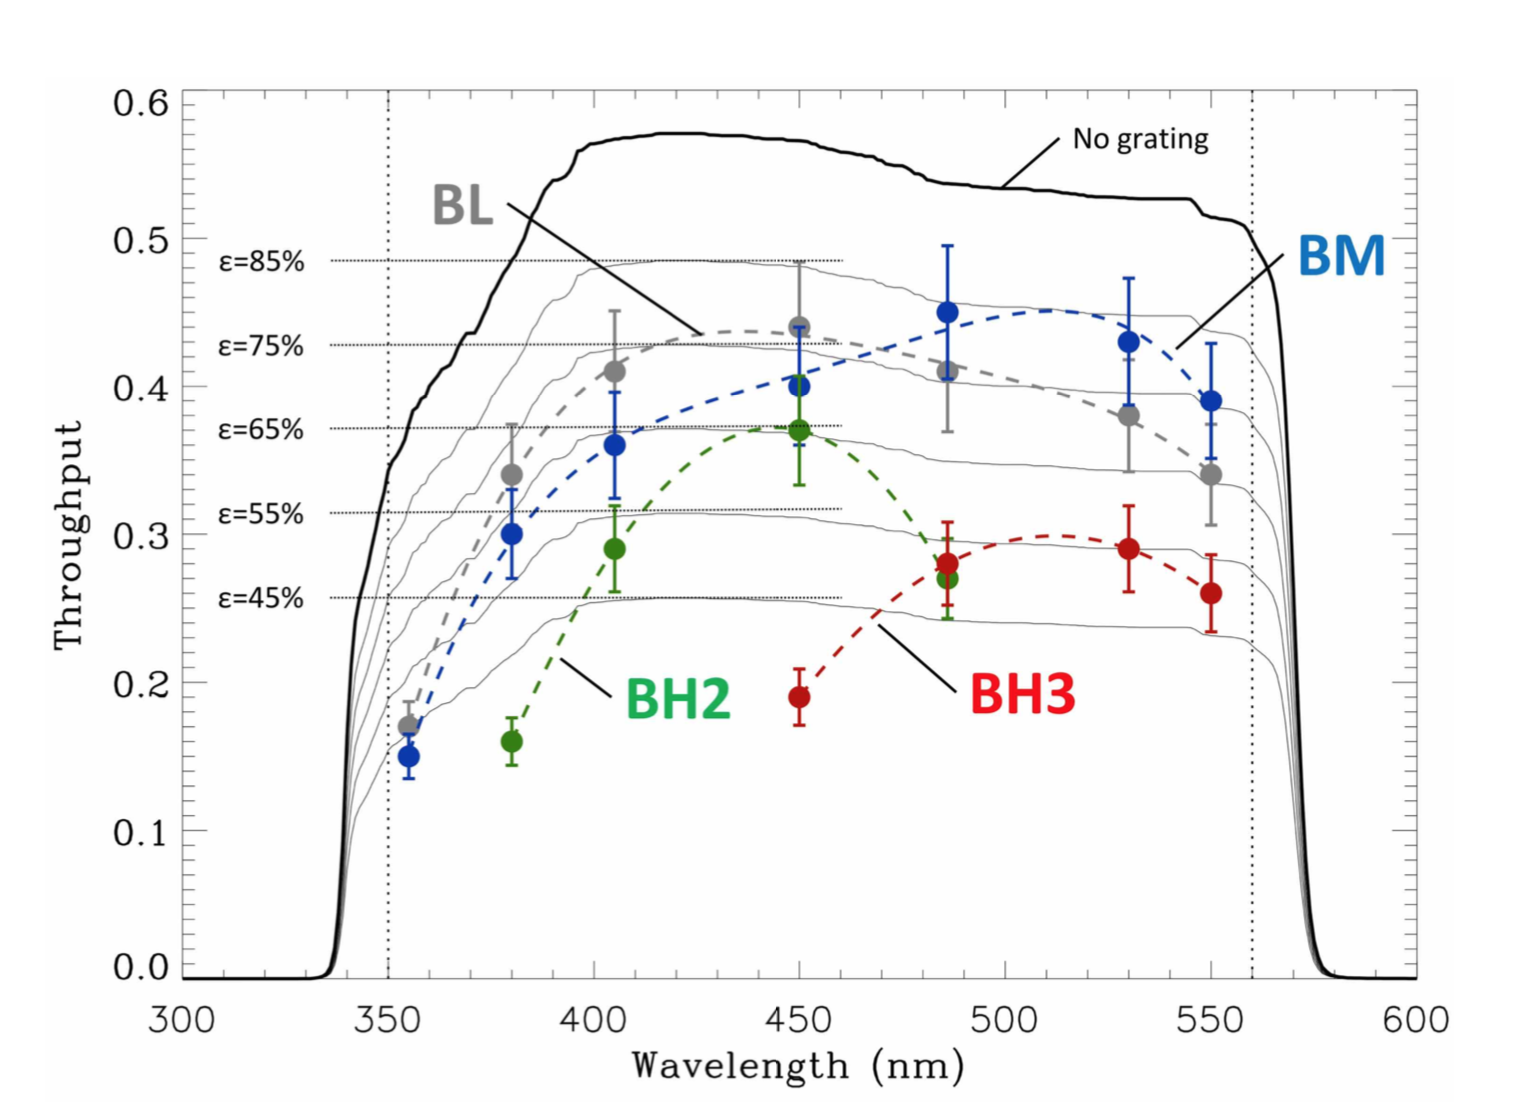
</div>
img source: Matuszewski M., Martin D.C., et al., The Keck Cosmic Web Imager Integral Field Spectrograph, doi:10.3847/1538-4357/aad597

In [ ]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np
import shutil
from astropy.modeling import models, fitting
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import interpolate
import ipywidgets as widgets

In [ ]:
# Step 1:
#   Make Master Standard Star 
# ----------------------------------------------------------------------------------------
# This function performs fits for the inverse sensitivity and effective area using the 
# standard star sample available and the standard star exposure under the same setting 
# as the objects to be calibrated. The default is polynomial fit without making, but a
# spline fit is also available to use if the features get complicated.
# ----------------------------------------------------------------------------------------
# Call:
#    i_f, e_f = make_st(st_icube,st_file,*poly=True,*maskd=False,*deg=7,*mask=msk_file)
# ----------------------------------------------------------------------------------------
# Inputs:
#   Required:
#      st_icube:   (str) path to standard star icube, e.g. '/data/kb190101_00011_icubed.fits'
#       st_file:   (str) path to standard star sample, e.g. '/data/feige15.fits'
#   Optional:
#          poly:  (bool) True/False, whether to use polynomial fit, default is True
#          mskd:  (bool) True/False, input mask file if True, default is False
#           deg:   (int) degree of the polynomial fit, default deg = 7
#     mask_file:   (str) path to mask file (required if poly==False or mskd==True)
# ----------------------------------------------------------------------------------------
# Outputs:
#          plots:  inverse sensitivity and effective area, saved to the working directory
#         models:  fits for inverse sensitivity and effective area
# ----------------------------------------------------------------------------------------
# Notes:
#  1. Make sure both *icubed.fits and *dcubed.fits are there.
#  2. There are two ways to tweak the polynomial fit: Mask features and Change degree 
#     of polynomial fit.
#  3. The bluer end of the polynomial fit is tied with the data, but still need to tweak 
#     and make sure the redder end doesn not blow up.
# ----------------------------------------------------------------------------------------
# Reference:
#  1. KCWI Data Reduction Pipeline
#      https://github.com/Keck-DataReductionPipelines/KcwiDRP
#  2. Morrissey P., Matuszewski M., Martin D.C., et al., THE KECK COSMIC WEB
#     IMAGER INTEGRAL FIELD SPECTROGRAPH, doi:10.3847/1538-4357/aad597
#      https://arxiv.org/pdf/1807.10356.pdf
# ----------------------------------------------------------------------------------------
# Updates: 
#    Sep  7, 2020  W.Ning  Updated documentation.
#    Sep  6, 2020  W.Ning  Fixed issue in stardard star position.
#    Aug 29, 2020  W.Ning  Added spline fit. Updated documentation.
#    Aug 26, 2020  W.Ning  Created.
# ----------------------------------------------------------------------------------------

def make_st(icube,st_file,poly=True,maskd=False,deg=7,**kwargs):
    icube_f = icube.replace("icubed","icubes")
    dcube = icube.replace('icubed','dcubed')
    shutil.copy2(icube,icube_f)
    
    mask = kwargs['mask']
    
    st_hdr = fits.getheader(icube)
    st_data = fits.getdata(icube)
    
    # Get information
    expt = st_hdr['XPOSURE'] # Exposure time
    air = st_hdr['AIRMASS'] # Airmass
    w0 = st_hdr['CRVAL3'] # Wavelength Zeropoint
    dw = st_hdr['CD3_3'] # Angstroms per pixel
    ws = w0 + np.shape(st_data)[0]*dw # wavelength endpoint
    crpix = st_hdr['CRPIX3'] # Wavelength reference pixel
    wl = np.maximum(st_hdr['WAVGOOD0'],3500); wr = st_hdr['WAVGOOD1'] # Good wavelength range to work with
    wa0 = st_hdr['WAVALL0']; wa1 = st_hdr['WAVALL1'] # All wavelength range
    pad_y = st_hdr['DARPADY'] # DAR padding in y
    area = int(760000) # Keck II Effective area in cm^2
    gw = [int((wl-w0)/dw+10),int((wr-w0)/dw-10)] # Good wavelength pixel range
    gy = [pad_y, np.shape(st_data)[1]-pad_y] # Good y range
    wav = w0+(np.arange(np.shape(st_data)[0])+1)*dw 
    gwav_st = wav[gw[0]:gw[1]]

    # Find standard star
    sum_dat = np.sum(st_data[gw[0]:gw[1],gy[0]:gy[1],:],0)
    xmax = np.argmax(np.std(sum_dat,0))
    ymax = np.argmax(sum_dat[:,xmax])+gy[0]

    # Read Keck Extinction data
    atm_data = fits.getdata('snfext.fits')

    # Extinction curve
    ext = np.interp(wav,atm_data.LAMBDA,atm_data.EXT)
    ext_flx = 10**(ext*air*0.4)
    
    with fits.open(icube_f, mode='update') as hdu:
        data = hdu[0].data
        for i in np.arange(np.shape(data)[0]):
            data[i,:,:] = data[i,:,:]*ext_flx[i]
        hdr = hdu[0].header
        hdr.append(('EXTCOR', 'T', ' Extinction corrected'), end=True)
        hdr.append(('AVEXCOR',np.mean(ext_flx),' Average extin. correction (flux ratio)'),end=True)
    hdu.close()
    
    st_corr = fits.getdata(icube_f)
    origspec = np.sum(np.sum(st_data[gw[0]:gw[1],ymax-30:ymax+30,xmax-3:xmax+3],1),1)/expt
    corrspec = np.sum(np.sum(st_corr[gw[0]:gw[1],ymax-30:ymax+30,xmax-3:xmax+3],1),1)/expt
    
    dcub = fits.getdata(dcube)[gw[0]:gw[1],ymax,xmax]
    
    # Standard Star sample
    st_profile = fits.getdata(st_file)
    stp_ind = np.logical_and(wl<st_profile.WAVELENGTH,st_profile.WAVELENGTH<wr)
    stp_l = st_profile.WAVELENGTH[stp_ind]
    stp_flx = st_profile.FLUX[stp_ind]
    stp_fwhm = np.max(st_profile.FWHM[stp_ind])
        
    # Inverse Sensitivity
    stp = np.interp(gwav_st,stp_l,stp_flx)
    invsen = stp / corrspec
        
    # Effective area
    st_pho = 5.03411250e07*stp*gwav_st*dw # convert to photons/s/cm^2/(wl bin = dw)
    earea = origspec/st_pho*dw / dcub
        
    # Fit with tied blue end
    p_init = models.Legendre1D(degree=deg); p_init.c0.fixed=True
    fit_p = fitting.LevMarLSQFitter()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        finvsen = fit_p(p_init,gwav_st-gwav_st[0],invsen-invsen[0])
    finvsen.c0.value = invsen[0]
    a_init = models.Legendre1D(degree=deg); a_init.c0.fixed=True
    fit_a = fitting.LevMarLSQFitter()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        fearea = fit_a(a_init,gwav_st-gwav_st[0],earea-earea[0])
    fearea.c0.value = earea[0]
        
    figtitle = 'Inverse Sensitivity and Effective Area - Poly'
    
    mod = 'poly'
    
    if maskd==True:
        # Mask
        msk = open(mask, "r")
        msk_data = msk.readlines()
        mskd = np.zeros((np.shape(msk_data)[0],2))
        for i in np.arange(np.shape(msk_data)[0]):
            mskd[i,0] = int(msk_data[i].split()[0])
            mskd[i,1] = int(msk_data[i].split()[1])
        gwav_ind=[0]*np.shape(gwav_st)[0];
        for i in np.arange(np.shape(msk_data)[0]):
            gwav_ind = np.add(gwav_ind, [int(np.logical_and(e>mskd[i][0],e<mskd[i][1])) for e in gwav_st])
        gwav = [gwav_st[int(ind)] for ind in np.argwhere(gwav_ind==0)]
        
        corrspec_m = [corrspec[int(ind)] for ind in np.argwhere(gwav_ind==0)]
        origspec_m = [origspec[int(ind)] for ind in np.argwhere(gwav_ind==0)]
        
        corrspec_c = np.interp(gwav_st,gwav,corrspec_m)
        origspec_c = np.interp(gwav_st,gwav,origspec_m)
        
        # Inverse Sensitivity
        stp = np.interp(gwav_st,stp_l,stp_flx)
        invsen_m = stp / corrspec_c
        
        # Effective area
        st_pho_m = 5.03411250e7*stp*gwav_st*dw # convert to photons/s/cm^2/(wl bin = dw)
        earea_m = origspec_c/st_pho_m*dw / dcub
        
        figtitle = 'Inverse Sensitivity and Effective Area - Masked Poly'
        
        # Fit with tied blue end
        p_init = models.Legendre1D(degree=deg); p_init.c0.value = 0; p_init.c0.fixed=True
        fit_p = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            finvsen = fit_p(p_init,gwav_st-gwav_st[0],invsen_m-invsen[0])
            finvsen.c0.value = invsen[0]
        a_init = models.Legendre1D(degree=deg); a_init.c0.value = 0; a_init.c0.fixed=True
        fit_a = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            fearea = fit_a(a_init,gwav_st-gwav_st[0],earea_m-earea[0])
        fearea.c0.value = earea[0]
        
    if poly==False:
        # Good points to use
        msk = open(mask, "r")
        points = msk.readlines()
        pts = [int(i.split()[0]) for i in points]
        gwav_ind=[0]*np.shape(gwav_st)[0];
        for i in pts:
            gwav_ind = np.add(gwav_ind, [int(i==e) for e in gwav_st])
        corrspec_m = [corrspec[int(ind)] for ind in np.argwhere(gwav_ind==1)]
        origspec_m = [origspec[int(ind)] for ind in np.argwhere(gwav_ind==1)]
        
        corrspec_c = np.interp(gwav_st,pts,corrspec_m)
        origspec_c = np.interp(gwav_st,pts,origspec_m)
        
        # Inverse Sensitivity
        stp = np.interp(gwav_st,stp_l,stp_flx)
        invsen_m = stp / corrspec_c
        
        # Effective area
        st_pho_m = 5.03411250e7*stp*gwav_st*dw # convert to photons/s/cm^2/(wl bin = dw)
        earea_m = origspec_c/st_pho_m*dw / dcub
            
        # Fit
        finvsen = interpolate.InterpolatedUnivariateSpline(gwav_st,invsen_m)
        fearea = interpolate.InterpolatedUnivariateSpline(gwav_st,earea_m)
        
        figtitle = 'Inverse Sensitivity and Effective Area - Spline'
        mod = 'spline'
    
    
    # Plotting
    f = make_subplots(rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.01)
    f.add_trace(go.Scatter(x=gwav_st,y=invsen,name='InvData'),row=1,col=1)
    f.add_trace(go.Scatter(x=gwav_st,y=earea,name='EffAreaData'),row=2,col=1)
    if poly == True:
        f.add_trace(go.Scatter(x=gwav_st,y=finvsen(gwav_st-gwav_st[0]),name='InvFit'),row=1,col=1)
        f.add_trace(go.Scatter(x=gwav_st,y=fearea(gwav_st-gwav_st[0]),name='EffAreaeFit'),row=2,col=1)
    else:
        f.add_trace(go.Scatter(x=gwav_st,y=finvsen(gwav_st),name='InvFit'),row=1,col=1)
        f.add_trace(go.Scatter(x=gwav_st,y=fearea(gwav_st),name='EffAreaFit'),row=2,col=1)
    f.update_layout(height=800,width=800,title=figtitle)
    f.show()
    f.write_image(figtitle+'.png')
    
    
    invsen_fit = np.recarray((1,),dtype=[('wav','O'),('invsen','O'),('model','O'),('fit','O')])
    effarea_fit = np.recarray((1,),dtype=[('wav','O'),('earea','O'),('model','O'),('fit','O')])
    
    invsen_fit.wav[0] = gwav_st; effarea_fit.wav[0] = gwav_st; 
    invsen_fit.invsen[0] = invsen; effarea_fit.earea[0] = earea;
    invsen_fit.fit[0] = finvsen; effarea_fit.fit[0] = fearea;
    invsen_fit.model[0] = mod; effarea_fit.model[0] = mod;
    
    return invsen_fit,effarea_fit

In [ ]:
# Step 1 Poly Example
i_f,e_f = make_st('kb190101_00011_icubed.fits','feige15.fits')

In [ ]:
# Step 1 Masked Poly Example
i_f,e_f = make_st('kb190101_00011_icubed.fits','feige15.fits',deg=6,maskd=True,mask='mask.txt')

In [ ]:
# Step 1 Spline Example
i_f,e_f = make_st('kb190101_00011_icubed.fits','feige15.fits',poly=False,mask='points.txt')

In [ ]:
# Step 2:
#   Calibration for object
# ----------------------------------------------------------------------------------------
# This function performs flux calibration for the object with results from step 1.
# ----------------------------------------------------------------------------------------
# Call:
#    stage8std(obj_icub,i_f)
# ----------------------------------------------------------------------------------------
# Inputs:
#      obj_icub:   (str) path to object intensity cube, e.g. '/data/kb190101_00011_icubed.fits'
#           i_f:   (arr) structured array containing the inverse sentivity fit from step 1
# ----------------------------------------------------------------------------------------
# Outputs:
#     datacubes:  calibrated datacubes (*icubes,*vcubes,*mcubes)
# ----------------------------------------------------------------------------------------
# Notes:
#  1. Put variance and mask datacubes in the same directory as the intensity cubes
#  2. The data beyond the good range is set to zero.
# ----------------------------------------------------------------------------------------
# Updates: 
#    Aug 29, 2020   W.Ning  Updated
#    Aug 26, 2020   W.Ning  Created
# ----------------------------------------------------------------------------------------

def stage8std(obj,i_f):
    vfil = obj.replace('icubed','vcubed'); mfil = obj.replace('icubed','mcubed')
    var_f = obj.replace('icubed','vcubes'); msk_f = obj.replace('icubed','mcubes')
    obj_f = obj.replace('icubed','icubes')
    hdr = fits.getheader(obj); st_data = fits.getdata(obj);
    shutil.copy2(obj,obj_f); shutil.copy2(vfil,var_f); shutil.copy2(mfil,msk_f)
    
    # Get Information
    expt = hdr['XPOSURE']
    air = hdr['AIRMASS']
    w0 = hdr['CRVAL3']; dw = hdr['CD3_3']
    wav = w0+(np.arange(np.shape(st_data)[0]))*dw 
    wl = np.maximum(hdr['WAVGOOD0'],3500); wr = hdr['WAVGOOD1']
    gw = [int((wl-w0)/dw+10),int((wr-w0)/dw-10)]
    
    # Extinction Correction
    if i_f.model[0]=='poly':
        st = i_f.fit[0](wav-i_f.wav[0][0])
    if i_f.model[0]=='spline':
        st = i_f.fit[0](wav)
    
    # Read Keck Extinction data
    atm_data = fits.getdata('snfext.fits')

    # Extinction curve
    ext = np.interp(wav,atm_data.LAMBDA,atm_data.EXT)
    ext_flx = 10**(ext*air*0.4)
    
    st = st*ext_flx
    
    with fits.open(obj_f, mode='update') as hdu:
        data = hdu[0].data
        for i in np.arange(np.shape(data)[0]):
            if np.logical_and(i>gw[0],i<gw[1]):
                data[i,:,:] = (data[i,:,:]/expt)*st[i]*1e16
            else:
                data[i,:,:] = 0
    hdu.close()
    
    with fits.open(var_f, mode='update') as hdu:
        data = hdu[0].data
        for i in np.arange(np.shape(data)[0]):
            if np.logical_and(i>gw[0],i<gw[1]):
                data[i,:,:] = data[i,:,:]*(st[i]*1e16/expt)**2
            else:
                data[i,:,:] = 0
    hdu.close()
     
    for file in [obj_f,var_f,msk_f]:
        with fits.open(file, mode='update') as hdu:
            hdr = hdu[0].header
            hdr.append(('EXTCOR', 'T', ' Extinction corrected'), end=True)
            hdr.append(('AVEXCOR',np.mean(ext_flx),' Average extin. correction (flux ratio)'),end=True)
            hdr.append(('STDCOR','T',' Std corrected?'), end=True)
            hdr.append(('BUNIT','FLAM16**2',' brightness units (Flam*10^16)^2'), end=True)
        hdu.close()

In [ ]:
stage8std('kb190101_00021_icubed.fits',i_f)